In [853]:
import sys
sys.path.append("/Users/mn/Desktop/Final_Project/cs238_final_project/marc")

In [854]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_based import *
from evaluator import *
import json
import re
import matplotlib.pyplot as plt

In [855]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [856]:
mdp_data=pd.read_csv('/Users/mn/Desktop/Final_Project/cs238_final_project/data/transition_matrix_train_int.csv')
mdp_data.head()

,Unnamed: 0,s,a,r,sp
0,0,1,1,-1.128571,2
1,1,2,2,-1.000000,3
2,2,3,2,-0.742857,2
3,3,2,3,-1.000000,4
4,4,4,3,-0.485714,3


In [857]:
states = mdp_data['s'].unique()
actions = mdp_data['a'].unique()

state_to_index = {state: i for i, state in enumerate(states)}
action_to_index = {action: j for j, action in enumerate(actions)}
index_to_state = {i: state for i, state in enumerate(states)}
index_to_action = {j: action for j, action in enumerate(actions)}

num_states = len(states)
num_actions = len(actions)


In [858]:
num_states

64

In [859]:
R,T,V=Value_Iteration(mdp_data,state_to_index,action_to_index,convergence_threshold=1e-9,gamma=0.4)

All rows of T sum to 0 or 1: True
Invalid row sums (if any): []


In [860]:
policy_indeces=policy_extraction(num_states,num_actions,R,T,V)
policy = [index_to_state[p] for p in policy_indeces]
with open('/Users/mn/Desktop/Final_Project/cs238_final_project/data/int_to_state.json', 'r') as file:
    int_to_state = json.load(file)

In [861]:
#OUR POLICY
max_steps=60
optimal_policy_rewards,resulting_states = simulate_policy_on_all_s(policy_indeces, num_states, num_actions,T, R,max_steps)

#RANDOM POLICY
random_policy = np.zeros(num_states, dtype=int)
for s in range(num_states):
    feasible_actions = [a for a in range(num_actions) if T[s * num_actions + a].sum() > 0]
    random_policy[s] = np.random.choice(feasible_actions) if feasible_actions else 0

baseline_rewards,resulting_states_rand = simulate_policy_on_all_s(random_policy,num_states, num_actions,T, R,max_steps)

print("Average Cumulative Reward (Optimal Policy):", optimal_policy_rewards)
print("Average Cumulative Reward (Random Baseline):", baseline_rewards)


Average Cumulative Reward (Optimal Policy): 24.66339285714286
Average Cumulative Reward (Random Baseline): -12.434598214285714


In [862]:
ini_and_final_states = get_cd4_and_vl_from_rollouts(resulting_states,int_to_state)
changes = evaluate_change_policies(ini_and_final_states)
results = check_improvment_ratio(changes)
results



(52, 10, 1, 1)

In [863]:
steps_results=[]
for i in range(60):
    optimal_policy_rewards,resulting_states = simulate_policy_on_all_s(policy_indeces, num_states, num_actions,T, R, i+1)
    ini_and_final_states = get_cd4_and_vl_from_rollouts(resulting_states,int_to_state)
    changes = evaluate_change_policies(ini_and_final_states)
    results = check_improvment_ratio(changes)
    steps_results.append(results)

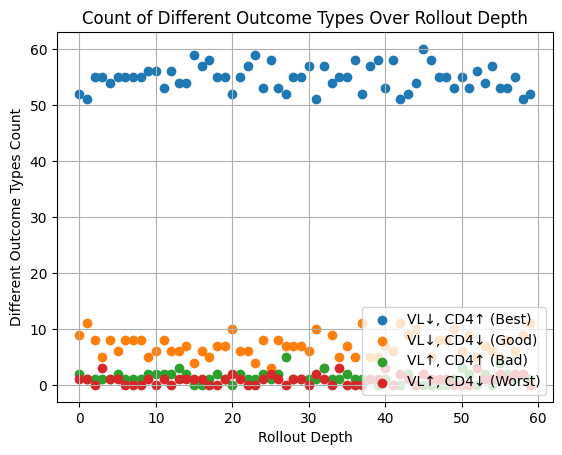

In [864]:
steps_results = np.array(steps_results)

# Generate indices for x-axis
indices = np.arange(len(steps_results))

# Column names
column_labels = [
    "VL↓, CD4↑ (Best)",
    "VL↓, CD4↓ (Good)",
    "VL↑, CD4↑ (Bad)",
    "VL↑, CD4↓ (Worst)"
]

# Plot each column as a scatter plot
for col in range(steps_results.shape[1]):
    plt.scatter(indices, steps_results[:, col], label=column_labels[col])

# Add labels, title, and legend
plt.xlabel('Rollout Depth')
plt.ylabel('Different Outcome Types Count')
plt.title('Count of Different Outcome Types Over Rollout Depth')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [865]:
policy_df = pd.DataFrame({
    'State': [index_to_state[s] for s in range(num_states)],
    'Optimal_Action': [index_to_action[policy[s]] for s in range(num_states)],
    'Optimal_Value': V
})

policy_df.to_csv('optimal_policy.csv', index=False)

policy_df.head(n=len(policy_df))

,State,Optimal_Action,Optimal_Value
0,1,16,-1.128571
1,2,16,-1.000000
2,3,17,-0.458911
3,4,16,-0.128163
4,5,16,-0.087993
...,...,...,...
59,60,15,0.960850
60,61,2,1.189346
61,62,15,1.110190
62,63,10,-0.844112
